# The HFM library - A fast marching solver with adaptive stencils

## Part : Non holonomic metrics and curvature penalization
## Chapter : Customized curvature penalization

This notebook presents a re-implementation of the Reeds-Shepp sub-Riemannian model, using a three dimensional Riemannian metric of strong anisotropy on a domain with suitable periodic boundary conditions.

Two customizations are then discussed, in connection with an image processing application, tubular structure segmentation. 
* *curvature prescription*, instead of curvature penalization
* *deviation from horizontality*, a data-driven modification of the original sub-Riemannian model

We then show how a similar effect can be achieved with other non-holonomic models implemented in the HFM library, which implement different and often stronger forms of curvature penalization. Namely the Reeds-Sheep *forward* model (without reverse gear), the Euler elastica model (squared penalization of curvature), and the Dubins model (uniform bound on curvature).

**Reader notice**. A general knowledge of the Reeds-Shepp sub-Riemannian model is required in the first part of this notebook.

**Acknowledgement**. This notebook is part of a work in progress in collaboration with [Remco Duits](https://www.win.tue.nl/~rduits/), [Erik Bekkers](https://erikbekkers.bitbucket.io), [Laurent Cohen](https://www.ceremade.dauphine.fr/~cohen/), and [Da Chen](https://www.researchgate.net/profile/Da_Chen9). 

**References**. The experiments presented in this notebook are inspired by the following publications.

Duits, R., Meesters, S. P., Mirebeau, J.-M., & Portegies, J. M. (2018). Optimal paths for variants of the 2D and 3D Reeds-Shepp car with applications in image analysis. Journal of Mathematical Imaging and Vision, 1–33. http://doi.org/ https://doi.org/10.1007/s10851-018-0795-z

Chen, D., Mirebeau, J.-M., & Cohen, L. D. (2015). Global Minimum for Curvature Penalized Minimal Path Method. In M. W. J. Xianghua Xie & G. K. L. Tam (Eds.), (pp. 86.1–86.12). Presented at the Proceedings of the British Machine Vision Conference (BMVC), BMVA Press. http://doi.org/10.5244/C.29.86

In [1]:
import sys; sys.path.append("..") # Allow imports from parent directory

In [2]:
from Miscellaneous import TocTools; TocTools.displayTOC('DeviationHorizontality','FMM')

[**Main summary**](Summary.ipynb) of this series of notebooks. [(view online)](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks_FMM/DeviationHorizontality.ipynb)


# Table of contents

 * [1. Re-creating the Reeds-Shepp model.](#1.-Re-creating-the-Reeds-Shepp-model.)
 * [2. A synthetic tubular segmentation problem](#2.-A-synthetic-tubular-segmentation-problem)
 * [3. Tubular structure extraction - cost based methods](#3.-Tubular-structure-extraction---cost-based-methods)
  * [3.1 Isotropic metric](#3.1-Isotropic-metric)
  * [3.2 Reeds-Shepp metric](#3.2-Reeds-Shepp-metric)
  * [3.3 Possible issues](#3.3-Possible-issues)
 * [4. Data-driven customization of the Reeds-Shepp model](#4.-Data-driven-customization-of-the-Reeds-Shepp-model)
  * [4.1 Deviation from horizontality](#4.1-Deviation-from-horizontality)
  * [4.2 Prescribing curvature](#4.2-Prescribing-curvature)
  * [4.3 Combining deviation from horizontality and curvature prescription](#4.3-Combining-deviation-from-horizontality-and-curvature-prescription)
 * [5. Other curvature penalization models](#5.-Other-curvature-penalization-models)
  * [5.1 The extended Reeds-Shepp model](#5.1-The-extended-Reeds-Shepp-model)
  * [5.2 Other models](#5.2-Other-models)




This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay


## 0. Importing the required libraries

In [4]:
import HFMUtils

In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Plots 3D paths

useMayavi = False
if useMayavi:
    from mayavi import mlab # Plots implicit surfaces

In [6]:
figSaveDir = 'Figures/C1/'

## 1. Re-creating the Reeds-Shepp model. 

The Reeds-Shepp model is presumably the most well known instance a *sub-Riemannian* model. This is empirically described as a Riemannian model whose metric tensors have infinite eigenvalues. Our implementation is based on relaxation of the sub-Riemannian constraint, replacing these infinite eigenvalues with a suitably large value denoted $\varepsilon^{-2}$.

The Reeds-Shepp model is posed on the three dimensional domain $R^2 \times S^1$, whose third dimension is periodic.
The relaxed metric, at position $(x,\theta)$ and evaluated on tangent vector $(\dot x, \dot \theta)$, reads
$$
    F_{(x,\theta)}(\dot x, \dot \theta) = <\dot x,n(\theta)>^2 
    + \varepsilon^{-2} <\dot x,n(\theta)^\perp> 
    + \xi^2 |\dot \theta|^2,
$$
where $n(\theta) := (\cos \theta, \sin \theta)$.
The parameter $\xi>0$, homogeneous to a length, balances the amount of curvature penalization, and should be regarded as a typical radius of curvature. 

The Reeds-Shepp model corresponds to the cost of motion of a wheelchair-like vehicle. The coordinates $(x,\theta)\in R^2 \times S^1$ reflect the current state of the vehicle, comprised of a position $x$ and an orientation $\theta$.
The three terms appearing in this metric dictate respectively 
* The cost of forward motion, in the direction $n(\theta)$.
* An extremely large price for lateral motion, in the direction $n(\theta)^\perp$. Such motions are forbidden for the vehicles considered, and their cost tends to $\infty$ as $\epsilon \to 0$.
* The cost of angular motion.

**Anticipation** The first step of this notebook is to reproduce the original Reeds-Shepp model. Let us nevertheless anticipate on the data-driven, application dependent, customizations that we will develop.
* *State dependent cost*. Multiplying the whole metric by a data-driven cost function $c(x,\theta)^2$, smaller in regions where motion should be favored.
* *Deviation from horizontality*. Replacing $n(\theta)$ with a data driven direction $n(x,\theta)$, corresponding to a locally preferred direction of motion.
* *Prescribed curvature*. Subtracting $\kappa <n(\theta),\dot x>$, where $\kappa$ is a reference curvature, to the angular motion speed $\dot \theta$. The same effect can be achieved in other ways as well.

In [7]:
eps = 0.1 # Small parameter, for penalizing the sub-Riemannian constraint.
xi = 0.5 # Typical radius of curvature.

We use the domain $[-1,1] \times [-0.4,0.4] \times [-\pi,\pi]$, with periodic boundary conditions on the last coordinate.

In [199]:
hfmIn=HFMUtils.Rect([-1,-0.4,-np.pi],[1,0.4,np.pi],dims=[101,40,101])
hfmIn.update({
    'model':'Riemann3_Periodic', # The third dimension is periodic (and only this one), in this model.
    'seeds':np.array([[0.,0.,0.]]),
    'arrayOrdering':'RowMajor',
    'tips':[[x,y,t] for x in HFMUtils.CenteredLinspace(-1,1,4) 
            for y in HFMUtils.CenteredLinspace(-0.5,0.5,2)
           for t in [0,np.pi/3,2*np.pi/3]],
})
X,Y,Theta = HFMUtils.GetGrid(hfmIn)
zero = 0.*X

In [200]:
def Outer(v):
    """Outer product of a vector with itself"""
    return np.array([[v[i]*v[j] for i in range(3)] for j in range(3)])

In [201]:
ReedsSheppMetric = (
    Outer([np.cos(Theta), np.sin(Theta),zero])
    + eps**(-2)*Outer([-np.sin(Theta),np.cos(Theta),zero])
    + xi**2*Outer([zero,zero,1+zero])
)

In [202]:
hfmIn['metric'] = np.transpose(HFMUtils.FlattenSymmetricMatrix(ReedsSheppMetric),(1,2,3,0))

In [203]:
hfmOut = HFMUtils.Run(hfmIn)

The planar projections of the Reeds-Shepp minimal geodesics feature *cusps*, which are characteristic feature of sub-Riemannian models.

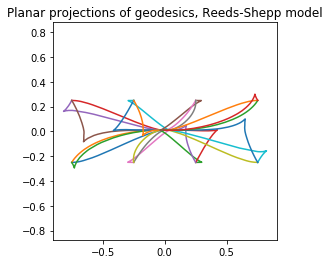

In [204]:
fig = plt.figure(figsize=[4,4]); plt.title('Planar projections of geodesics, Reeds-Shepp model'); plt.axis('equal'); 
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 

Note that the genuine three dimensional geodesics in $R^2 \times S^1$ are smooth.

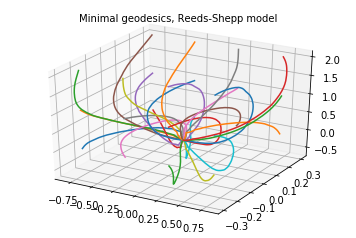

In [205]:
fig = plt.figure(); ax = fig.gca(projection='3d'); HFMUtils.SetTitle3D(ax,"Minimal geodesics, Reeds-Shepp model")
for geo in HFMUtils.GetGeodesics(hfmOut):
    ax.plot(geo[:,0],geo[:,1],geo[:,2])

## 2. A synthetic tubular segmentation problem

We construct a synthetic tubular segmentation problem, designed to illustrate minimal path based tubular extraction methods. The test case is chosen so as to induce the following difficulties:
* *Shortcuts* due to multiple crossings.
* *Strong curvature*, in some regions.

The image segmentation methods considered feature a preliminary filtering phase in which a number of features of the objects of interest are extracted. In particular it is typical to process, with more or less accuracy, the following quantities:
* A vesselness score, which is high on the tubular structure, and low elsewhere. 
* Some approximation of the tubular structure orientation.
* Some (weak) approximation of the tubular structure curvature.

In this synthetic test case, we do not attempt to implement the varied and complex image processing techniques involved to extract the above quantities, but directly construct them from the data.

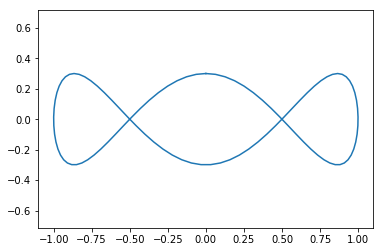

In [206]:
# The curve to be extracted in the synthetic test case
gamma_height = 0.3
def gamma(t):
    return np.sin(t), gamma_height*np.cos(3*t)
T = np.linspace(0,2*np.pi,100)
plt.axis('equal')
plt.plot(*gamma(T));

In [207]:
# First and second derivatives
def gamma_p(t):
    return np.cos(t), -3*gamma_height*np.sin(3*t)
def gamma_pp(t):
    return -np.sin(t), -9*gamma_height*np.cos(3*t)

# Tangent and curvature
def gamma_tgt(t):
    vx,vy = gamma_p(t)
    norm = (vx**2+vy**2)**0.5
    return vx/norm, vy/norm
def gamma_curv(t):
    vx,vy = gamma_p(t)
    ax,ay = gamma_pp(t)
    return (vx*ay-vy*ax)/(vx**2+vy**2)**(3/2.)

# Lift in R^2 x S^1 with the angular coordinate
def gamma_lift(t):
    return (*gamma(t), np.arctan2(*np.flip(gamma_p(t))) )
#def gamma_lift_p(t):
#    vx,vy = gamma_p(t)
#    speed = np.sqrt(vx**2+vy**2)
#    return vx,vy,speed*gamma_curv(t)

In [208]:
gamma_x, gamma_y = gamma(T)
gamma_tgt_x, gamma_tgt_y = gamma_tgt(T)
gamma_theta = np.arctan2(gamma_tgt_y,gamma_tgt_x)
gamma_c = gamma_curv(T)

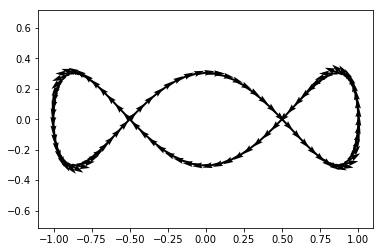

In [209]:
plt.axis('equal')
plt.quiver(gamma_x,gamma_y,gamma_tgt_x,gamma_tgt_y);

In [210]:
#plt.axis('equal')
#plt.quiver(gamma_x,gamma_y,-gamma_tgt_y/gamma_c,gamma_tgt_x/gamma_c,scale=1)

We use a fast marching method to compute the distance to the curve $\gamma$, which will be used to emulate a vesselness score. We also extend the tangent vector and curvature defined on $\gamma$ to the whole domain, based on the nearest value.

A small cost is used for the vertical coordinate, to account for the fact that a tubular structure direction is more difficult to extract thant its position. 

In [211]:
IsotropicMetric = np.array([
    [1.,0.,0.],
    [0.,1.,0.],
    [0.,0.,0.1**2] 
])

In [212]:
hfmIn.update({
    'metric' : HFMUtils.FlattenSymmetricMatrix(IsotropicMetric),
    'seeds' : np.transpose( (gamma_x,gamma_y,gamma_theta) ),
    'seedValueVariation' : [gamma_tgt_x, gamma_tgt_y, gamma_c],
    'exportValues' : 1,
})

In [213]:
hfmOut = HFMUtils.Run(hfmIn)

In [214]:
gamma_dist = hfmOut['values']
gamma_tgt_x_ext, gamma_tgt_y_ext, gamma_c_ext = np.transpose(hfmOut['valueVariation'],(3,0,1,2))

In [215]:
if useMayavi:
    mlab.contour3d(gamma_dist, contours=[0.1])
    mlab.show() # Displays in an external window.

This is what the previous command should display.
![Solution level set](https://rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/images/A9_CurveNeighborhood.png)

In [216]:
#plt.axis('equal')
#plt.quiver(X[::5,::5,0],Y[::5,::5,0],gamma_tgt_x_ext[::5,::5,30],gamma_tgt_y_ext[::5,::5,30]);

In [217]:
for key in ['metric','seedValueVariation','exportValues']: hfmIn.pop(key)

## 3. Tubular structure extraction - cost based methods

In order to extract a tubular structure of interest, one first produces a cost function that is decreasing w.r.t. the vesselness score. Here it is based on simulated data.

In [218]:
gamma_cost = 1/( 0.3 + np.exp(-(gamma_dist/0.2)**2) )

Then one can multiply a given base metric by the cost function, and extract the shortest path between two given points of the domain.

### 3.1 Isotropic metric

We apply the previous strategy with an isotropic metric.

In [219]:
dims_t = tuple(hfmIn['dims'].astype(int))
IsotropicMetric_Cost =  gamma_cost**2 * IsotropicMetric.reshape(3,3,1,1,1)

In [220]:
hfmIn.update({
    'metric':np.transpose(HFMUtils.FlattenSymmetricMatrix(IsotropicMetric_Cost),(1,2,3,0)),
    'seeds':[gamma_lift(-1.)],
    'tips':[gamma_lift(1.)],  
})

In [221]:
hfmOut = HFMUtils.Run(hfmIn)

 The tubular structure extraction fails, due to the *shortcuts problem*: since curvature is not penalized, the extracted path may jump from one branch of the tubular structure to another.

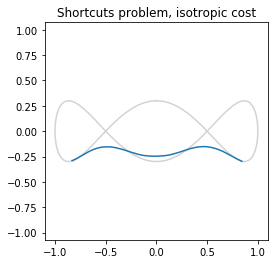

In [222]:
fig = plt.figure(figsize=[4,4]); plt.title('Shortcuts problem, isotropic cost'); plt.axis('equal'); 
plt.plot(*gamma(T),color='lightgray')
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 

### 3.2 Reeds-Shepp metric

Using a scaled Reeds-Shepp metric, we may both favor curves close to the tubular structure, and penalize curvature hence also shortcuts.

In [223]:
ReedsSheppMetric_Cost = gamma_cost**2 * ReedsSheppMetric

In [224]:
hfmIn['metric'] = np.transpose(HFMUtils.FlattenSymmetricMatrix(ReedsSheppMetric_Cost),(1,2,3,0))

In [225]:
hfmOut = HFMUtils.Run(hfmIn)

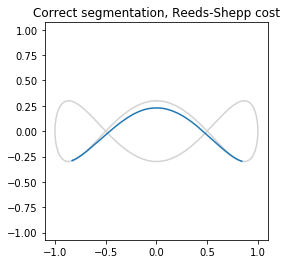

In [226]:
fig = plt.figure(figsize=[4,4]); plt.title('Correct segmentation, Reeds-Shepp cost'); plt.axis('equal'); 
plt.plot(*gamma(T),color='lightgray')
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 

### 3.3 Possible issues

The curvature penalization introduced with the Reeds-Shepp model may however create new difficulties, for at least two causes:
* *Sensitivity to the endpoints orientation*. If the angular coordinate of the seed or the tip is not correctly estimated, then the accuracy of the tubular structure extraction is degraded.
* *Difficulty to extract strongly curved portions*. Because of the curvature penalization, some parts of the tubular structure are hard to extract.

In [227]:
# Setting an incorrect orientation at the seed and tip
hfmIn.update({
    'seeds':[[*gamma(-1.),-0.5]],
    'tips':[[*gamma(1.),-1]],  
})

In [228]:
hfmOut = HFMUtils.Run(hfmIn)

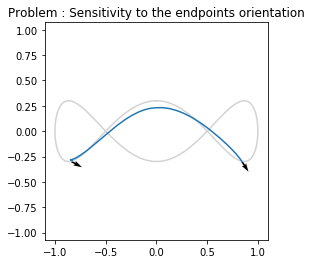

In [229]:
fig = plt.figure(figsize=[4,4]); plt.title('Problem : Sensitivity to the endpoints orientation'); plt.axis('equal'); 
plt.plot(*gamma(T),color='lightgray')
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 
for x,y,theta in list(hfmIn['seeds'])+list(hfmIn['tips']): plt.quiver(x,y,np.cos(theta),np.sin(theta))

Note the bad guess (user provided) of the endpoints orientation.

In [230]:
hfmIn.update({
    'seeds':[gamma_lift(-1.)],
    'tips':[gamma_lift(1.9)],  
})

In [231]:
hfmOut = HFMUtils.Run(hfmIn)

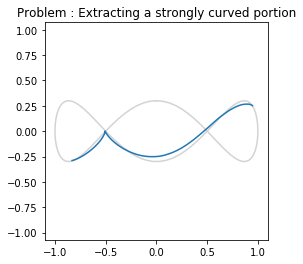

In [232]:
fig = plt.figure(figsize=[4,4]); plt.title('Problem : Extracting a strongly curved portion'); plt.axis('equal'); 
plt.plot(*gamma(T),color='lightgray')
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 

## 4. Data-driven customization of the Reeds-Shepp model

We present two modifications of the Reeds-Shepp model, designed to address the issues presented in 3.3.

### 4.1 Deviation from horizontality

The sub-Riemannian model is modified by forward motion direction $n(\theta) := (\cos \theta, \sin \theta)$ with an estimate of the tubular structure tangent direction, here produced synthetically. This compensates for a possible bad estimation of the tubular structure endpoints position or orientation.

The wording **Deviation from horizontality** is due to Remco Duits and refers to the sub-Riemannian terminology, in which the allowed directions of motion are referred to as the *horizontal* plane.

In [233]:
# Estimate of the curve tangent direction
tx,ty = gamma_tgt_x_ext, gamma_tgt_y_ext

ReedsSheppMetric_CostDeviation = gamma_cost**2 * (
    Outer([tx, ty,zero])
    + eps**(-2)*Outer([-ty,tx,zero])
    + xi**2*Outer([zero,zero,1+zero])
)

In [234]:
hfmIn.update({
    'metric':np.transpose(HFMUtils.FlattenSymmetricMatrix(ReedsSheppMetric_CostDeviation),(1,2,3,0)),
    'seeds':[[*gamma(-1.),-0.5]],
    'tips':[[*gamma(1.),-1]],  
})

In [235]:
hfmOut = HFMUtils.Run(hfmIn)

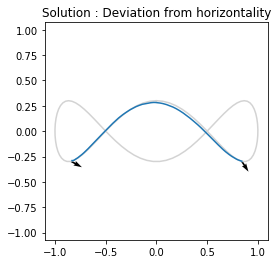

In [236]:
fig = plt.figure(figsize=[4,4]); plt.title('Solution : Deviation from horizontality'); plt.axis('equal'); 
plt.plot(*gamma(T),color='lightgray')
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 
for x,y,theta in list(hfmIn['seeds'])+list(hfmIn['tips']): plt.quiver(x,y,np.cos(theta),np.sin(theta))

Note the resilience to the bad guess (user provided) of the endpoints orientation.

### 4.2 Prescribing curvature

The extracted path curvature is not penalized absolutely, but with respect to some reference value, estimated from the tubular structure to be extracted. (Here produced synthetically.)

This eliminates a spurious penalization of the path segments overlaid on strongly curved portions of the tubular structure. 

This effect can be achieved in two ways:
* Adequate modification of the Reeds-Shepp model.
* Construction of a cigar-shaped Riemannian metric in $R^2 \times S^1$, meaning that at each point the symmetric tensor has two large eigenvalues, while one is small. <!---(Note : strictly speaking, this is not a sub-Riemannian model.)-->

In [237]:
# First approach : modifying the Reeds-Shepp model
ReedsSheppMetric_CostCurv = gamma_cost**2 * (
    Outer([np.cos(Theta), np.sin(Theta),zero])
    + eps**(-2) * Outer([-np.sin(Theta), np.cos(Theta),zero])
    + xi**2 * Outer([gamma_c_ext*np.cos(Theta), gamma_c_ext*np.sin(Theta),-1+zero])
)

In [238]:
hfmIn.update({    
    'metric':np.transpose(HFMUtils.FlattenSymmetricMatrix(ReedsSheppMetric_CostCurv),(1,2,3,0)),
    'seeds':[gamma_lift(-1.)],
    'tips':[gamma_lift(1.9)],  
})

In [239]:
hfmOut = HFMUtils.Run(hfmIn)

The strongly curved bottom-right portion of the curve is now correctly extracted.

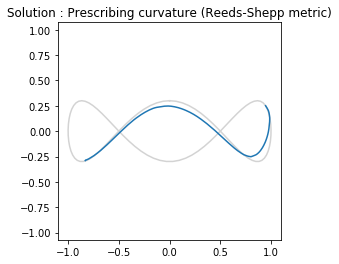

In [240]:
fig = plt.figure(figsize=[4,4]); plt.title('Solution : Prescribing curvature (Reeds-Shepp metric)'); plt.axis('equal'); 
plt.plot(*gamma(T),color='lightgray')
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 

In [241]:
# Second approach : cigar-shaped metric
v_Curv = np.array([np.cos(Theta), np.sin(Theta), gamma_c_ext])
v_Curv /= np.sqrt(v_Curv[0]**2+v_Curv[1]**2+v_Curv[2]**2)

Identity = np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])

CigarMetric_CostCurv = gamma_cost**2 * (
    Outer(v_Curv)
    + eps**(-2)*(Identity.reshape((3,3,1,1,1))-Outer(v_Curv))
)

In [242]:
hfmIn['metric']=np.transpose(HFMUtils.FlattenSymmetricMatrix(CigarMetric_CostCurv),(1,2,3,0))

In [243]:
hfmOut = HFMUtils.Run(hfmIn)

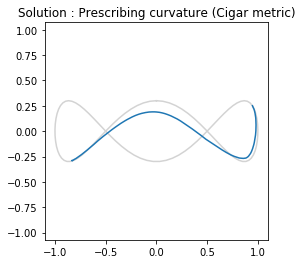

In [244]:
fig = plt.figure(figsize=[4,4]); plt.title('Solution : Prescribing curvature (Cigar metric)'); plt.axis('equal'); 
plt.plot(*gamma(T),color='lightgray')
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 

### 4.3 Combining deviation from horizontality and curvature prescription

The two previously methods can be combined, so as to extract highly curved tubular structures with inaccurate endpoints orientation. Again, one can either modify the Reeds-Shepp model, or produce a cigar-shaped Riemannian metric.

In [249]:
# First approach : modifying the Reeds-Shepp model
tx,ty = gamma_tgt_x_ext, gamma_tgt_y_ext

ReedsSheppMetric_CostDeviationCurv = gamma_cost**2 * (
    Outer([tx, ty,zero])
    + eps**(-2) * Outer([-ty, tx,zero])
    
    # We here increase a bit curvature penalization 
    + (3*xi)**2 * Outer([gamma_c_ext*tx, gamma_c_ext*ty,-1+zero])
)

In [250]:
hfmIn.update({
    'metric':np.transpose(HFMUtils.FlattenSymmetricMatrix(ReedsSheppMetric_CostDeviationCurv),(1,2,3,0)),
    'seeds':[[*gamma(-1.),-0.5]], 
    'tips':[[*gamma(1.9),1]],  # Strong curvature portion, bad endpoints orientation
})

In [251]:
hfmOut = HFMUtils.Run(hfmIn)

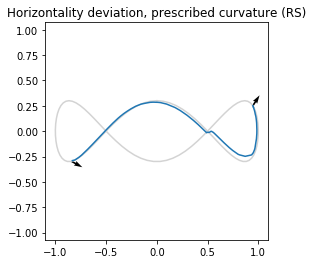

In [252]:
fig = plt.figure(figsize=[4,4]); plt.title('Horizontality deviation, prescribed curvature (RS)'); plt.axis('equal'); 
plt.plot(*gamma(T),color='lightgray')
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 
for x,y,theta in list(hfmIn['seeds'])+list(hfmIn['tips']): plt.quiver(x,y,np.cos(theta),np.sin(theta))

Note the resilience to the high curvature portions, and to the bad guesses (user provided) of the endpoints tangents.

**TODO** Understand what happens at the second crossing.

In [253]:
# Cigar shaped construction
v_DeviationCurv = np.array([gamma_tgt_x_ext, gamma_tgt_y_ext, gamma_c_ext])
v_DeviationCurv /= np.sqrt(v_DeviationCurv[0]**2+v_DeviationCurv[1]**2+v_DeviationCurv[2]**2)

CigarMetric_CostDeviationCurv = gamma_cost**2 * (
    Outer(v_DeviationCurv)
    + eps**(-2)*(Identity.reshape((3,3,1,1,1))-Outer(v_DeviationCurv))
)

In [254]:
hfmIn.update({    
    'metric':np.transpose(HFMUtils.FlattenSymmetricMatrix(CigarMetric_CostDeviationCurv),(1,2,3,0)),
    'seeds':[[*gamma(-1.),-0.5]],
    'tips':[[*gamma(1.9),1]],  
})

In [255]:
hfmOut = HFMUtils.Run(hfmIn)

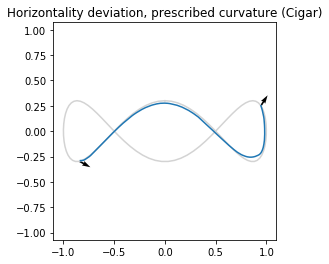

In [256]:
fig = plt.figure(figsize=[4,4]); plt.title('Horizontality deviation, prescribed curvature (Cigar)'); plt.axis('equal'); 
plt.plot(*gamma(T),color='lightgray')
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 
for x,y,theta in list(hfmIn['seeds'])+list(hfmIn['tips']): plt.quiver(x,y,np.cos(theta),np.sin(theta))

## 5. Other curvature penalization models


### 5.1 The extended Reeds-Shepp model

We reproduce the above experiment using the extended Reeds shepp model.

In [311]:
hfmIn = {
    'model':'ReedsSheppExt2',
    'eps':eps, # Relaxation parameter
    'arrayOrdering':'RowMajor',    
    
    'seeds':[[*gamma(-1.),-0.5]],
    'tips':[[*gamma(1.9),1]],  
}
hfmIn.update(HFMUtils.Rect([-1,-0.4],[1,0.4],dimx=101))

In [312]:
hfmIn['dims'] = np.append(hfmIn['dims'],101)

In [313]:
X2,X2,Theta2 = HFMUtils.GetGrid(hfmIn)

In [314]:
angleDiff = np.roll(Theta[0,0,:],51)-Theta2[0,0,:]
np.max(np.abs(angleDiff*(2.*np.pi+angleDiff)))

5.58058959681381e-15

In [315]:
hfmIn.update({
    'cost' : np.roll(gamma_cost,51),
    'xi' : 3*xi, # Typical radius of curvature 
    'theta' : np.roll(np.arctan2(gamma_tgt_y_ext,gamma_tgt_x_ext),51), # Deviation from horizontality
    'kappa' : np.roll(gamma_c_ext,51), # Reference curvature
})

In [316]:
hfmOut = HFMUtils.Run(hfmIn)

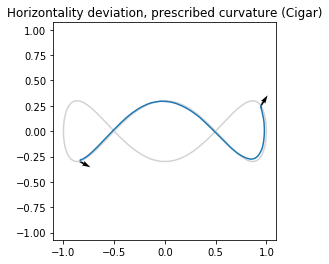

In [317]:
fig = plt.figure(figsize=[4,4]); plt.title('Horizontality deviation, prescribed curvature (Cigar)'); plt.axis('equal'); 
plt.plot(*gamma(T),color='lightgray')
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 
for x,y,theta in list(hfmIn['seeds'])+list(hfmIn['tips']): plt.quiver(x,y,np.cos(theta),np.sin(theta))

### 5.2 Other models

The same parameters apply to the extended Reeds-Shepp forward, Euler elastica, and Dubins models. 

In [329]:
hfmIn['model'] = 'ElasticaExt2_5'

In addition, since these models are asymmetric, even greater portions of the tubular structure can be extracted in a single run

In [332]:
hfmIn['tips'] = [gamma_lift(3.1)]

In [330]:
hfmOut = HFMUtils.Run(hfmIn)

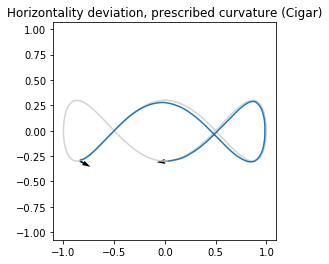

In [331]:
fig = plt.figure(figsize=[4,4]); plt.title('Horizontality deviation, prescribed curvature (Cigar)'); plt.axis('equal'); 
plt.plot(*gamma(T),color='lightgray')
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 
for x,y,theta in list(hfmIn['seeds'])+list(hfmIn['tips']): plt.quiver(x,y,np.cos(theta),np.sin(theta))

Also, exchanging the role of the seeds and tips allows to extract the other portion of tube. 

In [333]:
hfmIn['seeds'],hfmIn['tips'] = hfmIn['tips'],hfmIn['seeds']

In [334]:
hfmOut = HFMUtils.Run(hfmIn)

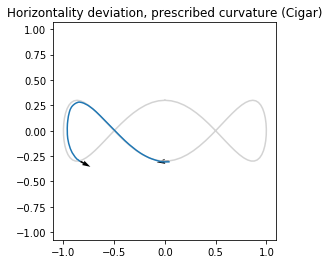

In [335]:
fig = plt.figure(figsize=[4,4]); plt.title('Horizontality deviation, prescribed curvature (Cigar)'); plt.axis('equal'); 
plt.plot(*gamma(T),color='lightgray')
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 
for x,y,theta in list(hfmIn['seeds'])+list(hfmIn['tips']): plt.quiver(x,y,np.cos(theta),np.sin(theta))